# **Dependancies**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime

from tqdm import tqdm

from collections import Counter
from scipy.stats import uniform
from scipy.stats import randint
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, PredefinedSplit
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from collections import Counter
from scipy.stats import uniform
from scipy.stats import randint


In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# **Loading Data**

In [3]:
selected = pd.read_csv("../Data/train_ltc_selected_features.csv")
btc = pd.read_csv("../Data/litecoin_Data.csv")
btc['Date'] = pd.to_datetime(btc['Date'])
btc = btc.set_index("Date")

In [4]:
btcData = btc[selected.columns]
btcData['returns'] = btcData['priceUSD'].pct_change().copy()
Data = btcData.drop(columns=['priceUSD'])
Data = Data[1:]
# divide X and Y
X = Data.iloc[:,0:]
#Y = Data['returns']   # 用returns的话就用这一行，然后把下一行comment掉
Y = btcData['priceUSD'].shift(-30)[1:] # 反之亦然
# Split into three data sets
X_train = X['2016-01-01':'2019-12-31']
X_val = X['2020-01-01':'2021-05-31']
X_test = X['2021-06-01':'2023-01-01']

Y_train = Y['2016-01-01':'2019-12-31']
Y_val = Y['2020-01-01':'2021-05-31']
Y_test = Y['2021-06-01':'2023-01-01']

/tmp/ipykernel_203080/3854812091.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btcData['returns'] = btcData['priceUSD'].pct_change().copy()


In [5]:
X_train.shape

(1460, 31)

In [6]:
estimators=[]
estimators.append(['mixmax',MinMaxScaler()])
estimators.append(['robust',RobustScaler()])
scale=Pipeline(estimators,verbose=True)
scale.fit(X_train)
X_train=scale.transform(X_train)
X_test=scale.transform(X_test)
X_val = scale.transform(X_val)

[Pipeline] ............ (step 1 of 2) Processing mixmax, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing robust, total=   0.0s


In [7]:
X_train = pd.DataFrame(X_train)
X_val = pd.DataFrame(X_val)
X_test = pd.DataFrame(X_test)

In [8]:
X_train.shape

(1460, 31)

In [9]:
# r2_oos
def r2_oos(ret, pred):
    sum_of_sq_res = np.nansum(np.power((ret-pred), 2))
    sum_of_sq_total = np.nansum(np.power(ret, 2))
    
    return 1-sum_of_sq_res/sum_of_sq_total

In [10]:

r2oos_score = make_scorer(r2_oos, greater_is_better=True)  

In [11]:

# Random Forest
#use pipeline to + a scaler（standardize）, then use gridsearchcv/randomsearchcv
def rf(X_train, y_train, X_valid, y_valid, gridsearch = True):
   
    rf_clf = RandomForestRegressor(random_state=43)
    param_grid = dict(n_estimators=[300],
                    max_depth=randint(2,8),
                     max_features=randint(3,100))
    
    # use two scorer:r2oos and mse 
    # scoring_dict = ['r2oos_score', 'neg_mean_squared_error']
    scoring_dict = {'r2_oos':r2oos_score, 'mse':'neg_mean_squared_error'}

    # The indices which have zero or positive values, will be kept in val
    len_X_train = len(X_train)
    len_X_val = len(X_valid)
    val_fold = np.repeat([-1, 0], [len_X_train, len_X_val])
    ps = PredefinedSplit(val_fold)

    X_train_n_val = pd.concat([X_train, X_valid])
    y_train_n_val = pd.concat([y_train, y_valid])
    # notice the cv=ps
    if gridsearch:
        grid = GridSearchCV(rf_clf, param_grid, cv=ps, n_jobs=8, verbose=2, scoring= scoring_dict, refit='r2_oos')
    else:
        grid = RandomizedSearchCV(rf_clf, param_grid, cv=ps, n_jobs=8, n_iter=15, verbose=2, scoring= scoring_dict, refit ='r2_oos') #could try n_iter=60 for better result

    grid.fit(X_train_n_val, y_train_n_val)

    #get the best score with grid.best_score_
    #get the best parameters with grid.best_params_
    #get the best model with grid.best_estimator_
    return grid

In [12]:
regressor = rf(X_train, Y_train, X_val, Y_val, False)

Fitting 1 folds for each of 15 candidates, totalling 15 fits
[CV] END .....max_depth=7, max_features=11, n_estimators=300; total time=   2.4s
[CV] END .....max_depth=3, max_features=61, n_estimators=300; total time=   2.8s
[CV] END .....max_depth=7, max_features=18, n_estimators=300; total time=   3.4s
[CV] END .....max_depth=2, max_features=34, n_estimators=300; total time=   2.3s
[CV] END .....max_depth=5, max_features=45, n_estimators=300; total time=   4.7s
[CV] END .....max_depth=5, max_features=85, n_estimators=300; total time=   4.8s
[CV] END .....max_depth=7, max_features=98, n_estimators=300; total time=   5.6s
[CV] END .....max_depth=6, max_features=97, n_estimators=300; total time=   5.8s
[CV] END .....max_depth=3, max_features=61, n_estimators=300; total time=   2.8s
[CV] END .....max_depth=6, max_features=67, n_estimators=300; total time=   6.8s
[CV] END ......max_depth=7, max_features=8, n_estimators=300; total time=   3.4s
[CV] END .....max_depth=6, max_features=80, n_es

In [13]:
y_pred=regressor.predict(X_test)

In [14]:
# for check
Y_train_pred=regressor.predict(X_train)
r2_score(Y_train, Y_train_pred) #training score

0.987943726047833

In [15]:
r2=r2_score(Y_test[:-30],y_pred[:-30]) #score/ r^2
print(f'r2:{r2}')

r2:0.2989509274670783


In [16]:
def r2_oos2(ret, pred):
    sum_of_sq_res = np.nansum(np.power((ret-pred), 2))
    sum_of_sq_total = np.nansum(np.power(ret, 2))
    
    return 1-sum_of_sq_res/sum_of_sq_total
r2_oos = r2_oos2(Y_test[:-30], y_pred[:-30])
print(f'r2_oos:{r2_oos}')

r2_oos:0.8717655457195391


In [17]:
mae=mean_absolute_error(Y_test[:-30],y_pred[:-30]) #mae
print(f'mae:{mae}')

rmse=np.sqrt(mean_squared_error(Y_test[:-30],y_pred[:-30])) #rmse
print(f'rmse:{rmse}')

mape=mean_absolute_percentage_error(Y_test[:-30],y_pred[:-30]) #mape
print(f'mape:{mape}')

mae:35.24156655622649
rmse:45.02585195648589
mape:33.72135630136823


-----------------------------

In [18]:
pre_df = pd.DataFrame(zip(Y_test,y_pred),columns=['Y_test','y_pred'])
pre_df.index = Y_test.index
pre_df

,Y_test,y_pred
Date,,
2021-06-01,137.796,150.040992
2021-06-02,133.855,151.852362
2021-06-03,138.441,152.963171
2021-06-04,143.405,149.573887
2021-06-05,139.483,170.340408
...,...,...
2022-11-24,NaN,192.126094
2022-11-25,NaN,183.166217
2022-11-26,NaN,173.501440


In [19]:
pre_df['pred_returns'] = pre_df['y_pred'].pct_change()

In [20]:
pre_df

,Y_test,y_pred,pred_returns
Date,,,
2021-06-01,137.796,150.040992,NaN
2021-06-02,133.855,151.852362,0.012073
2021-06-03,138.441,152.963171,0.007315
2021-06-04,143.405,149.573887,-0.022158
2021-06-05,139.483,170.340408,0.138838
...,...,...,...
2022-11-24,NaN,192.126094,-0.008739
2022-11-25,NaN,183.166217,-0.046635
2022-11-26,NaN,173.501440,-0.052765


<AxesSubplot:>

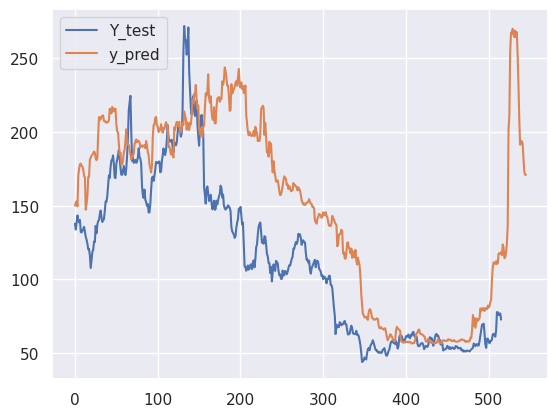

In [21]:
pd.DataFrame(zip(Y_test,y_pred),columns=['Y_test','y_pred']).plot()

In [22]:
pre_df.to_csv("ltc_rf.csv")

In [23]:

!kdeconnect-cli -n TAS-AN00 --ping-msg 'Script complete!'

Couldn't find device: TAS-AN00
